Dataset Shape: (50000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), ob

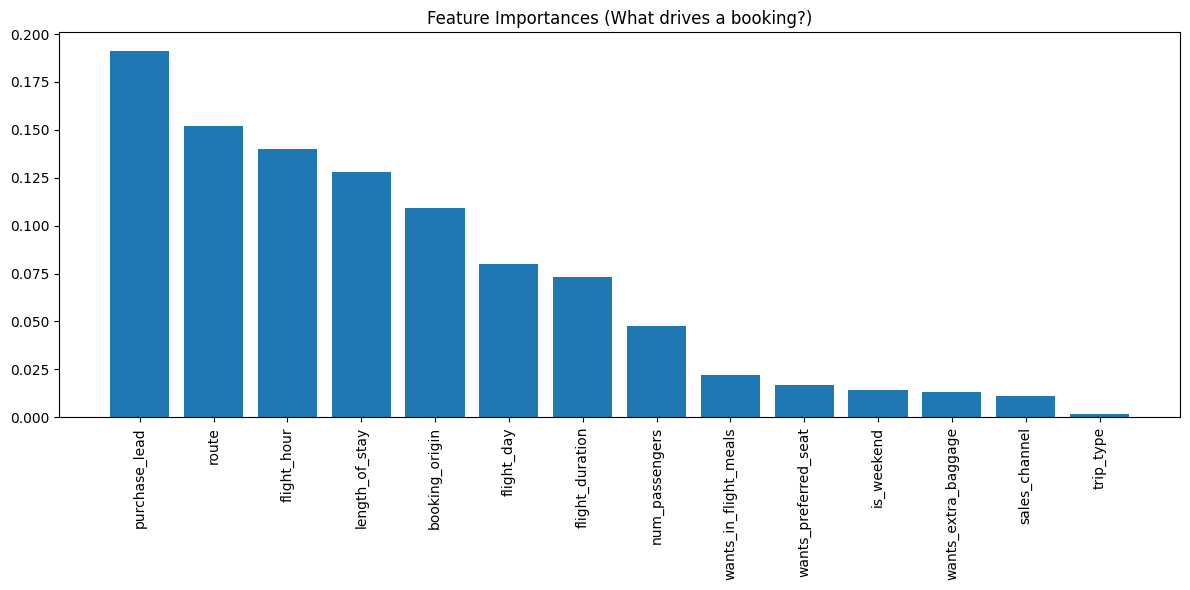

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 2. LOAD AND EXPLORE DATA ---
# Replace 'customer_booking.csv' with the actual path to your file
df = pd.read_csv('customer_booking.csv', encoding='ISO-8859-1')

print("Dataset Shape:", df.shape)
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# --- 3. DATA PREPARATION & FEATURE ENGINEERING ---

# A. Mapping 'flight_day' to numbers (Monday=1, Tuesday=2, etc.)
mapping = {
    "Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4,
    "Fri": 5, "Sat": 6, "Sun": 7
}
df["flight_day"] = df["flight_day"].map(mapping)

# B. Feature Engineering: Create a 'is_weekend' feature
# If flight day is Sat (6) or Sun (7), set to 1, else 0.
# This might help the model as leisure travel happens more on weekends.
df['is_weekend'] = df['flight_day'].apply(lambda x: 1 if x >= 6 else 0)

# C. Handling Categorical Variables
# The dataset likely has 'sales_channel', 'trip_type', 'route', 'booking_origin'
# We need to convert these text columns into numbers.
categorical_cols = df.select_dtypes(include='object').columns

# Using Label Encoding for high cardinality columns (like Route/Origin) to keep it simple
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# --- 4. MODEL TRAINING ---

# Define X (features) and y (target)
# 'booking_complete' is usually the target variable in this dataset
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

# Split into Train and Test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
# We use Random Forest as requested because it provides feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# --- 5. EVALUATION ---

# Make predictions
y_pred = rf_model.predict(X_test)

# Print Metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Cross-Validation (to ensure the model is stable)
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

# --- 6. FEATURE IMPORTANCE VISUALIZATION ---
# This is crucial for your slide
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plotting
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (What drives a booking?)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()